# HW 5 :
In this homework we will be looking at GAN on MNIST dataset . So far, deep learning have involved discriminative models, usually those that map a high-dimensional input to a class label.These are based on the backpropagation and dropout algorithms, using piecewise linear units which have a particularly well-behaved gradient.

The goal of a generative model is to take a small piece of input—perhaps a few random numbers—and produce a complex output, like an image of a realistic-looking face.

A generative adversarial network (GAN) is an especially effective type of generative model, introduced only a few years ago.

## Model Overview

A generative model (𝐺) is pitted against an adversary: a
discriminative (𝐷) model that learns to determine whether a sample is from the generative model distribution or the data distribution.

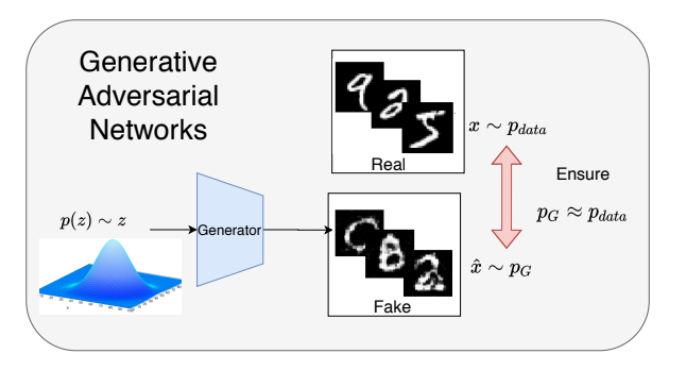

*   Introduce latent variable z with simple prior $p(𝑧)$ (e.g. Gaussian)
*   Sample $z ∼ p(𝑧)$, pass it through Generator $\hat{x} = G(z)$; where $\hat{x} ∼ p_G$
*   Introduce mechanism to ensure $p_G ≈ p_{data}$


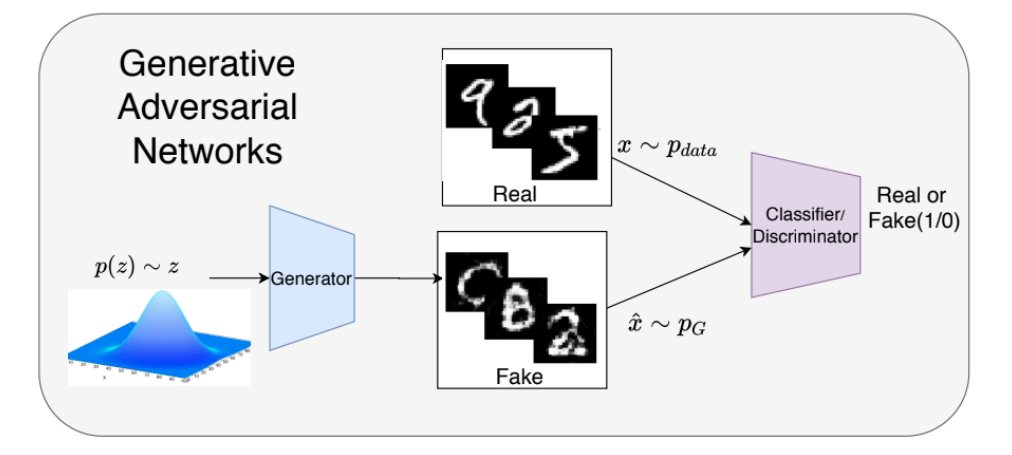

* Use a classifier (called discriminator) that differentiates between real samples $x ∼ p_{data} (class 1)$ and $\hat{x} ∼ p_{G} (class 0)$
* Train generator G such that discriminator misclassifies generated sample \hat{x} into class 1
=⇒ can no more differentiate between $x ∼ p_{data}$ and $\hat{x} ∼ p_{G}$

In [1]:
# Import Libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set for testing purposes, please do not change!
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


The below function is for visualizing images: Given a tensor of images, number of images, and size per image, plots and prints the images in a uniform grid.

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator Architecture

This function creates a single block for generator network given input_dim and output_dim

This block contains
1. Linear transformation to map to another shape,
  * in_features=input_dim
  * out_features=output_dim
2. Batch Normalization
  * num_features : output_dim
3. Activation Function (Relu)
  * inplace : True
  
  
Returns a generator neural network layer, with a linear transformation followed by a batch normalization and then a relu activation. We will be using this blocks to create a generator

In [3]:
def get_generator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=output_dim),
        nn.BatchNorm1d(num_features=output_dim),
        nn.ReLU(inplace=True)
    )

Below we implement a Generator Class

* Architecture of the Generator looks like this :

  z_dim : the dimension of the noise vector =10
  
  im_dim: dimension of the flattened images=784,
  
  hidden_dim=128
  * Generator block( 10 , 128)
  * Generator block( 128 , 128*2)
  * Generator block( 128 * 2 , 128 * 4)
  * Generator block( 128 * 4 , 128 * 8)
  * Linear layer
    * what should be the dimensions of the linear layer ?
  * Sigmoid Activation

A function for completing a forward pass of the generator. Given a noise tensor, returns generated images.





In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(

            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),

            # TODO 1: Generator Architecture
            #### START CODE HERE ####
            # Final Layer containing Linear transformation with in_features from previous layer and out_features as im_dim
             nn.Linear(in_features=(hidden_dim * 8), out_features=im_dim),
            # Sigmoid Activation Function
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

## Noise

To train generator, we need to create noise vectors.

This function generates noise vector by sampling random numbers from the normal distribution given
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type

In [5]:

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

## Discriminator Architecture

This function creates a single block for Discriminator network given input parameters

input_dim: the dimension of the input vector, a scalar

output_dim: the dimension of the output vector, a scalar

This block contains
1. Linear transformation to map to another shape,
  * in_features=input_dim, out_features=output_dim
2. Activation Function (Relu)
  * negative_slope = 0.2 , inplace =True

It returns a neural network block of the discriminator. We are going to stack many number of blocks to create Discriminator Architecture.

In [6]:
def get_discriminator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=output_dim),
        nn.LeakyReLU(negative_slope=0.2,inplace=True)
    )

In the Discriminator class we will build a network with 4 layers. Start with the image tensor and perform the transformation until it returns a single number (i.e. 1-dimensional tensor output)

Each intermediate layer in the network will have hidden_dim

Architecture of the Discriminator is as given below :

im_dim: the dimension of the flattened images, fitted for the dataset used, a scalar (MNIST images are 28x28 = 784 so that is your default)

hidden_dim: the inner dimension, a scalar

* Discriminator block( 784 , 128 * 4)
* Discriminator block( 128 * 4 , 128 * 2)
* Discriminator block( 128 * 2 , 128)
* Linear layer
  * what should be the dimensions of the linear layer ?

This has only linear transformation with in_features: hidden_dim and out_features: 1

In [7]:
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(

            get_discriminator_block(im_dim, hidden_dim * 4),

            # Layer-2
            get_discriminator_block(hidden_dim * 4,hidden_dim*2),

            # Layer-3
            get_discriminator_block(hidden_dim*2, hidden_dim),

            # TODO 2: Discriminator Architecture
            #### START CODE HERE ####
            nn.Linear(in_features=hidden_dim, out_features=1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

## Loading data

In [8]:

batch_size = 128

# Check availability of GPU and set the device accordingly
device = 'cuda'

# The following block is to mitigate the temporary issue within PyTorch about downloading MNIST. Don't change!
"""new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in MNIST.resources
]"""
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 56.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.92MB/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [9]:
z_dim = 64
# create a generator
gen = Generator(z_dim).to(device)

# create a discriminator
disc = Discriminator().to(device)


$$
\text { Training Objective: } \min _{G} \max _{D}\left(\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]+\mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z))])\right.
$$

$$
O_{1}=\max _{D} \mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]
$$
Train discriminator, $D$, such that if sample belongs to $p_{\text {data }}$, maximize the log probability of it being a real sample

$$
O_{2}=\min _{G} \mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z))]
$$
Train Generator, $G$ such that if sample belongs to $p_{G}($ i.e $G(z))$, maximize the log probability of it being a real sample

* for number of training iterations do

  * for $k$ steps do
    - Sample minibatch of $m$ noise samples from noise prior $p_{g}(\boldsymbol{z})$.
    - Sample minibatch of $m$ examples from data generating distribution $p_{\text {data }}(\boldsymbol{x}) .$
    - Update the discriminator by ascending its stochastic gradient:
$$
\nabla_{\theta_{d}} \frac{1}{m} \sum_{i=1}^{m}\left[\log D\left(\boldsymbol{x}^{(i)}\right)+\log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)\right]
$$
  * end for
  - Sample minibatch of $m$ noise samples $\left\{\boldsymbol{z}^{(1)}, \ldots, \boldsymbol{z}^{(m)}\right\}$ from noise prior $p_{g}(\boldsymbol{z})$.
  - Update the generator by descending its stochastic gradient:
$$
\nabla_{\theta_{g}} \frac{1}{m} \sum_{i=1}^{m} \log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)
$$
* end for

The gradient-based updates can use any standard gradient-based learning rule. We used momentum in our experiments.

## Discriminator loss function
This function returns the loss of the discriminator given inputs.

  * gen: the generator model, which returns an image given z-dimensional noise

  * disc: the discriminator model, which returns a single-dimensional prediction of real/fake

  * criterion: the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)

  * real: a batch of real images
  * num_images: the number of images the generator should produce, which is also the length of the real images

  * z_dim: the dimension of the noise vector, a scalar
  * device: the device type


Create noise vectors, use existing defined get_noise function to create noise. Pass this noise vectors as input to generate batch (num_images) of fake images using gen defined above.

These generated fake images are passed to discriminator for prediction  using disc defined above. Make sure to use .detach() on generator results i.e. fake.detach() since generator is needed to calculate discriminator loss.
This ensures that only the discriminator is updated

Calculate loss using criterion defined earlier.Ground truth for fake images are all zeros

Pass the batch of real images to discriminator for predictions using disc defined above

Calculate loss using criterion defined earlier. Ground truth for real images are all ones

Take avg of disc_fake_loss and disc_real_loss and return the average discriminator loss

In [10]:
def gen_fake(gen, num_images, z_dim, device):
  # TODO 3: Fake Image Generation
  #### START CODE HERE ####
  fake_noise = get_noise(num_images, z_dim, device="cuda")

  fake = gen(fake_noise)
  #### END CODE HERE ####
  return fake

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake = gen_fake(gen, num_images, z_dim, device)

    # TODO 4: Discriminator Loss Function
    #### START CODE HERE ####

    disc_fake_pred = disc(fake.detach())

    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

    disc_real_pred = disc(real)

    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

    #### END CODE HERE ####
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss


## Generator Loss function

This function gives loss of the Generator given inputs
* gen: the generator model, which returns an image given z-dimensional noise
* disc: the discriminator model, which returns a single-dimensional prediction of real/fake
* criterion: the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)
* num_images: the number of images the generator should produce, which is also the length of the real images
* z_dim: the dimension of the noise vector, a scalar
* device: the device type



Create noise vectors, use existing defined get_noise function to create noise, ensure use of device argument.

Pass this nosie vectors to generate a batch (num_images) of fake images by using gen defined above.

Also collect Discriminator predictions on the above generated fake images using disc defined earlier

Calculate generator loss using criterion.For Ground truth remember that generator wants discriminator to think that fake images are real

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake = gen_fake(gen, num_images, z_dim, device)

    # TODO 5: Generator Loss Function
    #### START CODE HERE ####

    disc_fake_pred = disc(fake)

    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    #### END CODE HERE ####
    return gen_loss

# Display Image

In [13]:
def show_image():
  from torchvision.utils import make_grid
  fake_noise = torch.rand(128,z_dim,device=device)
  fake = gen(fake_noise)
  unflattened_image = fake.detach().cpu().view(-1, *(1, 28, 28))
  loss = get_gen_loss(gen, disc, criterion, 128, z_dim, device)
  image_grid = make_grid(unflattened_image[:25], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

## Training

  0%|          | 0/469 [00:00<?, ?it/s]

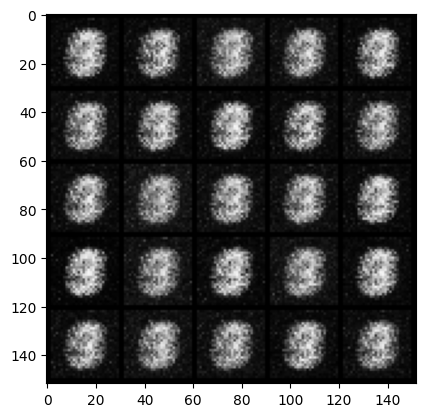

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 Step 500: Generator loss: 1.3880696054697037, discriminator loss: 0.41926278406381584


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 Step 1000: Generator loss: 1.6689348356723788, discriminator loss: 0.30029824081063267


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 Step 1500: Generator loss: 1.9591862142086023, discriminator loss: 0.1741809245646


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 Step 2000: Generator loss: 1.7617196171283729, discriminator loss: 0.19575063824653632


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 Step 2500: Generator loss: 1.7262575557231892, discriminator loss: 0.19497746112942707


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 Step 3000: Generator loss: 2.0247795815467846, discriminator loss: 0.1511020245850085


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 Step 3500: Generator loss: 2.4035883226394636, discriminator loss: 0.12550739951431755


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 Step 4000: Generator loss: 2.7104416403770464, discriminator loss: 0.12410872893035418


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 Step 4500: Generator loss: 3.1942318019866924, discriminator loss: 0.09882975330203764


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 Step 5000: Generator loss: 3.4725079741477973, discriminator loss: 0.08025063819438215


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 Step 5500: Generator loss: 3.7240899906158464, discriminator loss: 0.08110867780447016


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 Step 6000: Generator loss: 3.7576497054100058, discriminator loss: 0.07708885996788738


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 Step 6500: Generator loss: 3.897636411190035, discriminator loss: 0.06381551358103747


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 Step 7000: Generator loss: 3.9793471426963825, discriminator loss: 0.05146120115742085


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 Step 7500: Generator loss: 4.170833583354951, discriminator loss: 0.048137523863464565


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 Step 8000: Generator loss: 4.040672773361205, discriminator loss: 0.05803466045111414


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 Step 8500: Generator loss: 4.0962597360611, discriminator loss: 0.05771748365461824


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
generator_losses = []
discriminator_losses = []

# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
display_step = 500
lr = 0.00001

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True  # Whether the generator should be tested
gen_loss = False
error = False

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        #### START CODE HERE ####

        # Zero out the gradients
        gen_opt.zero_grad()
        # Calculate generator loss, use existing function get_gen_loss defined for loss calculation
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        # Backprop through the generator: update the gradients
        gen_loss.backward(retain_graph=True)
        # Update optimizer
        gen_opt.step()
        #### END CODE HERE ####

        if test_generator:  # For testing purposes, to check that your code changes the generator weights
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:  ### Visualization code ###
            print(f"Epoch {epoch} Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            image_unflat = fake.detach().cpu().view(-1, *(1, 28, 28))
            image_grid = make_grid(image_unflat[:25], nrow=5)
            save_image(image_grid, "training_image.png")

            # Store losses
            generator_losses.append(mean_generator_loss)
            discriminator_losses.append(mean_discriminator_loss)

            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

    if epoch % 50 == 0:
        show_image()

# Store final epoch losses
generator_losses.append(mean_generator_loss)
discriminator_losses.append(mean_discriminator_loss)


Below we create a fig file that you will include when submitting the homework. We recommend running this last once you've completed the notebook. Make sure to download fig.png to include with our ipynb file.

# Plot Loss


In [ ]:
# Plotting the Generator and Discriminator Losses
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
show_image()

In [ ]:
from torchvision.utils import save_image
save_image(image_grid,"fig.png")

References :
* Goodfellow et al, Generative Adversarial Nets, NeurIPS 2014
* Play with Generative Adversarial Networks (GANs) in your browser
https://poloclub.github.io/ganlab/

* Dive into Deep Learning, Chapter 17
https://d2l.ai/chapter_generative-adversarial-networks/gan.html

* Radford et al, Unsupervised Representation Learning with Deep Convolutional GANs, NeurIPS 2016